# 🔀 Data Splitting & Visualization

**Proper data splitting** is essential to ensure that the model is trained and validated on **distinct, representative subsets** of the data. This helps to:
- 🔒 **prevent data leakage**
- ⚖️ **reduce overfitting**
- 📈 **produce reliable performance estimates**

In this notebook, we load a small **fraction** of the MNIST dataset and use `sklearn.model_selection.train_test_split` to create **training** and **validation** sets with **stratification**, preserving the class distribution.

Equally important is **data visualization**. By visualizing sample images along with their labels, we can:
- 👀 **better understand the data**
- 🛑 **detect potential issues** like mislabeled or corrupted samples
- 💡 **gain intuition** about the problem before training any model

Together, **careful data splitting and visualization** lay the foundation for:
- 🛠️ **robust, interpretable**
- 🤝 **trustworthy machine learning workflows**



In [12]:
import os
import wandb
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt

### Loading MNIST dataset

In [13]:
def load_mnist(fraction=0.25):
    transform = transforms.ToTensor()
    mnist_train_full = datasets.MNIST(os.getcwd(), train=True, download=True, transform=transform)

    # Reduce training set if fraction < 1
    if 0 < fraction < 1.0:
        subset_size = int(fraction * len(mnist_train_full))
        mnist_train_full, _ = random_split(mnist_train_full, [subset_size, len(mnist_train_full) - subset_size])

    # Extract images and labels as tensors
    data = torch.stack([mnist_train_full[i][0] for i in range(len(mnist_train_full))])
    targets = torch.tensor([mnist_train_full[i][1] for i in range(len(mnist_train_full))])

    print(f"Loaded MNIST subset with {len(data):,} images.")
    print(f"Image tensor shape: {data.shape}")
    print(f"Labels tensor shape: {targets.shape}")

    return data, targets

In [14]:
images, targets = load_mnist()

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/torch/__init__.py", line 409, in <module>
    from torch._C import *  # noqa: F403
  File "<frozen importlib._bootstrap>", line 203, in _lock_unlock_module
KeyboardInterrupt
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction

Loaded MNIST subset with 15,000 images.
Image tensor shape: torch.Size([15000, 1, 28, 28])
Labels tensor shape: torch.Size([15000])


### Visualising MNIST dataset

In [15]:
def visualize_dataset_sample(idx=0):
    """This function visualizes a 
    single sample from the dataset by index."""    
    # Plot
    plt.figure(figsize=(3,3))
    
    image = images[idx].squeeze()
    label = targets[idx].item()
    
    plt.imshow(image, cmap='gray')
    plt.title(f"Lable={label}", fontsize=10)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


def plot_label_distribution(labels, title="Label Distribution"):
    """Plots a histogram of label counts to visualize class balance."""
    # Convert tensor to numpy for plotting
    label_array = labels.numpy()
    
    # Create histogram
    plt.figure(figsize=(8, 4))
    plt.hist(label_array, bins=range(11), align='left', rwidth=0.8, color='skyblue', edgecolor='black')
    
    # Add text and grid
    plt.title(title)
    plt.xlabel("Digit Label")
    plt.ylabel("Number of Samples")
    plt.xticks(range(10))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

#### Visualize one sample and the labels distribution

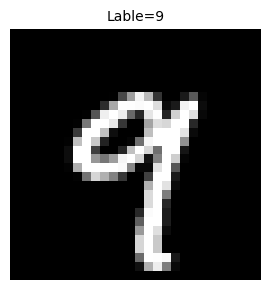

In [16]:
visualize_dataset_sample(idx=2)

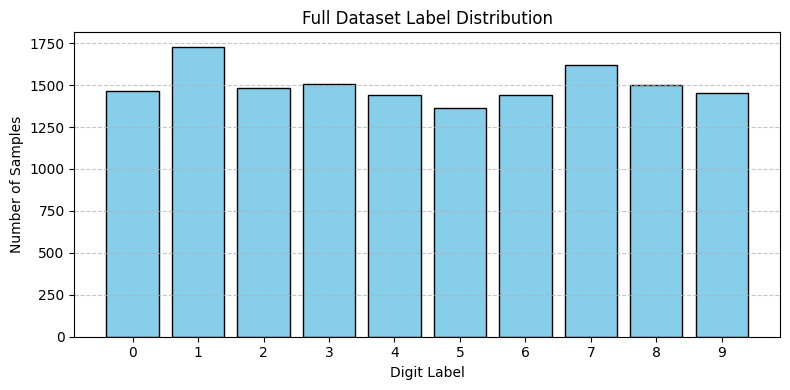

In [17]:
# Call the function on the full set or on splits
plot_label_distribution(targets, title="Full Dataset Label Distribution")

## ✂️ Dataset Split: Making a Train/Validation set

We start with the available dataset. It’s important to realize that **this is all the data we have**, and we must **decide how to split it** into training and validation sets.

To do this, we use `sklearn.model_selection.train_test_split`, which provides a flexible way to divide the data while optionally maintaining label distribution using **stratification**.

🧠 **Key point:**  
Choosing the right split ratio (e.g., 80/20 or 70/30) is part of the design decisions students must make. This decision impacts training quality and validation reliability of the model selection proces.

Let’s now define our split!

In [18]:
# Define split ratio
validation_ratio = 0.25 # TODO 

# Perform the split with stratification to maintain label balance
X_train, X_val, y_train, y_val = train_test_split(images, targets, test_size=validation_ratio, stratify=targets, random_state=42)

# Set as TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Check the size of the splits
print(f"Train set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")

Train set: 11250 samples
Validation set: 3750 samples


## ⚡ Model Architecture

In this notebook, we use a **fully connected neural network (MLP)** to classify handwritten digits from the MNIST dataset.

### 🧠 Model Structure:
- The network starts by **flattening** the 28×28 input image.
- Then, it passes through one or more **hidden layers** with **ReLU activations**.
- Finally, it outputs **10 logits** (one for each digit class).
- 
This structure is simple but effective for small image datasets like MNIST, and it allows us to explore the effect of **hyperparameters** such as:
- **Number of hidden units**
- **Number of layers**
- **Learning rate**
- **Optimizer** type (SGD or Adam).


In [19]:
# 1. Define the LightningModule
class LitMNIST(pl.LightningModule):
    def __init__(self, hidden=128, layers=2, lr=1e-3, optimizer='Adam'):
        super().__init__()
        # save hyperparameters
        self.save_hyperparameters()
        # set architecture
        model = [torch.nn.Flatten(),
                 torch.nn.Linear(28 * 28, hidden),
                 torch.nn.ReLU()]
        for i in range(layers-2):
            model.append(torch.nn.Linear(hidden, hidden))
            model.append(torch.nn.ReLU())
        model.append(torch.nn.ReLU()),
        model.append(torch.nn.Linear(hidden, 10))
        
        self.model = torch.nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        if self.hparams.optimizer == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.lr)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

## 🚀 Hyperparameter Optimization: W&B

When training machine learning models, **finding the best hyperparameter configuration** is crucial for achieving good performance. Instead of manually testing every combination, tools like **Weights & Biases (W&B)** automate this process by performing an efficient **search over the configuration space**.

With W&B, you can:

- **Define a search space** of hyperparameters like the number of hidden units, layers, learning rate, and optimizer type.
- **Run multiple training experiments** exploring different hyperparameter combinations.
- **Track and visualize results** in real-time on an interactive dashboard.
- **Identify the best configuration** based on your chosen evaluation metric (e.g., validation accuracy).

This approach helps you **systematically optimize your model** by ensuring.

It’s essential to set these three components clearly before starting the hyperparameter optimization.

1. **Hyperparameter search space** — specifying which parameters to explore and their possible values or ranges.  
2. **Clear optimization goal** — choosing the metric to maximize or minimize (e.g., validation accuracy).  
3. **Effective search method** — selecting how to explore the space (e.g., random search, grid search, Bayesian optimization).


Here is the hyperparameter configuration space we explore in this notebook:

| Hyperparameter           | Description                           | Example Values / Range    |
|-------------------------|-------------------------------------|--------------------------|
| **Number of Hidden Units** | Number of neurons in each hidden layer | 4, 32, 64                |
| **Number of Layers**       | Total hidden layers in the network     | 2, 4, 8                  |
| **Learning Rate (lr)**     | Step size for optimizer updates        | 1e-6 to 1e-1             |
| **Optimizer Type**         | Algorithm to update weights             | SGD, Adam                |


### Configuration Space

In [20]:
hyperopt_config = {
    "method": "random", #TODO "grid", "random", "bayes"
    "metric": {
        "name": "val_acc", # None,#TODO "val_acc", "train_acc", "val_loss", "train_acc"
        "goal": "maximize" #None #TODO "maximize", "minimize"
    },
    "parameters": {
        "lr": {
            "distribution": "log_uniform_values",
            "min": 1e-4,  #None #TODO 1e-2
            "max": 1e-3, #None #TODO 1e-3
        },
        "hidden": {
            "values": [64, 128] #TODO
        },
        "layers": {
            "values": [2, 8, 32] #TODO
        },
        "optimizer": {
            "values": ["Adam", "SGD"]
        }
    }
}

### Training and Evaluating Sampled Hyperparameter Sets

Weights & Biases (W&B) **samples hyperparameter configurations** from the defined configuration space to train the model and evaluate its performance. 

Each sampled configuration is used to run a full training cycle, logging metrics such as loss and accuracy, so we can compare different settings and identify the best-performing combination.


In [21]:
def train(config=None):
    
    # W&B provides with a configuration from the configuration space
    with wandb.init(config=config):
        args = wandb.config

    # Logger
    wandb_logger = WandbLogger(project="mnist-sweep", name=f"layers={args.layers}_hidden={args.hidden}_lr={args.lr:.0e}_Opt={args.optimizer}", log_model=False)

    # Set seed
    pl.seed_everything(42, workers=True)

    # Data Loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

    # Model instantiation
    model= LitMNIST(hidden=args.hidden, layers=args.layers, lr=args.lr, optimizer=args.optimizer)
    wandb_logger.watch(model, log="all")

 # save best trained model
    checkpoint_callback = ModelCheckpoint(monitor="val_acc", mode="max", save_top_k=1)


    # Trainer
    trainer = pl.Trainer(
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        max_epochs=5,
        logger=wandb_logger,
        callbacks=[checkpoint_callback],
        deterministic=True,
        num_sanity_val_steps=0
    )

    # Fit
    trainer.fit(model, train_loader, val_loader)

epoch,▁▁██
train_acc,▁█
train_loss,█▁
trainer/global_step,▁▁███
val_acc,▁█
val_loss,█▁
epoch,1
train_acc,0.1705
train_loss,2.28082
trainer/global_step,375
val_acc,0.189


In [11]:
# Create the sweep
sweep_id = wandb.sweep(hyperopt_config, project="mnist-sweep")

# Run the agent (you can change count to the number of trials)
wandb.agent(sweep_id, function=train, count=100)

Create sweep with ID: ke3z8ud0
Sweep URL: https://wandb.ai/amb_zgz/mnist-sweep/sweeps/ke3z8ud0


wandb: Agent Starting Run: t72djlnv with config:
wandb: 	hidden: 64
wandb: 	layers: 2
wandb: 	lr: 0.0005766821265498425
wandb: 	optimizer: Adam
wandb: Currently logged in as: mikel-martinez (amb_zgz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 50.9 K | train
---------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimi

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▇▇██
train_loss,█▂▂▁▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▅▆██
val_loss,█▄▂▁▁
epoch,4
train_acc,0.92817
train_loss,0.26286
trainer/global_step,939
val_acc,0.91467


wandb: Agent Starting Run: 8w8kkmq0 with config:
wandb: 	hidden: 64
wandb: 	layers: 2
wandb: 	lr: 0.0002421778118658856
wandb: 	optimizer: Adam


Seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 50.9 K | train
---------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimi

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▇▇██
train_loss,█▃▂▁▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▅▇██
val_loss,█▃▂▁▁
epoch,4
train_acc,0.90558
train_loss,0.35432
trainer/global_step,939
val_acc,0.90033


wandb: Agent Starting Run: exno2k5z with config:
wandb: 	hidden: 64
wandb: 	layers: 2
wandb: 	lr: 0.00012480785399918826
wandb: 	optimizer: SGD


Seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 50.9 K | train
---------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimi

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▂▄▆█
train_loss,█▆▄▃▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▂▄▆█
val_loss,█▆▄▃▁
epoch,4
train_acc,0.14558
train_loss,2.29032
trainer/global_step,939
val_acc,0.147


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3cmoh022 with config:
wandb: 	hidden: 64
wandb: 	layers: 8
wandb: 	lr: 0.00011934487364907804
wandb: 	optimizer: SGD


Seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 75.9 K | train
---------------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.303     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimi

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▁▁▁▁
train_loss,█▆▄▃▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▁▁▁▁
val_loss,█▆▄▃▁
epoch,4
train_acc,0.11008
train_loss,2.30493
trainer/global_step,939
val_acc,0.11033


wandb: Agent Starting Run: nd0szom1 with config:
wandb: 	hidden: 64
wandb: 	layers: 2
wandb: 	lr: 0.0003989616504577309
wandb: 	optimizer: SGD


Seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 50.9 K | train
---------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimi

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▃▅▆█
train_loss,█▆▅▃▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▃▅▆█
val_loss,█▆▅▃▁
epoch,4
train_acc,0.22908
train_loss,2.25335
trainer/global_step,939
val_acc,0.24367


wandb: Agent Starting Run: 7lb6lr05 with config:
wandb: 	hidden: 64
wandb: 	layers: 2
wandb: 	lr: 0.0007803916355096339
wandb: 	optimizer: Adam


Seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 50.9 K | train
---------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimi

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▆▇▇█
train_loss,█▂▂▁▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,4
train_acc,0.93983
train_loss,0.2274
trainer/global_step,939
val_acc,0.929


wandb: Agent Starting Run: q38pq1xy with config:
wandb: 	hidden: 64
wandb: 	layers: 8
wandb: 	lr: 0.00027951200767070667
wandb: 	optimizer: Adam


Seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 75.9 K | train
---------------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.303     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimi

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▆▇██
train_loss,█▃▂▁▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▅▇██
val_loss,█▃▂▁▁
epoch,4
train_acc,0.87842
train_loss,0.41551
trainer/global_step,939
val_acc,0.87133


wandb: Agent Starting Run: osljfiys with config:
wandb: 	hidden: 64
wandb: 	layers: 8
wandb: 	lr: 0.00021815638811362504
wandb: 	optimizer: SGD


Seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 75.9 K | train
---------------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.303     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimi

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▁▁▁▁
train_loss,█▆▄▃▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▁▁▁▁
val_loss,█▆▄▃▁
epoch,4
train_acc,0.11008
train_loss,2.30483
trainer/global_step,939
val_acc,0.11033


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gbc9dxot with config:
wandb: 	hidden: 64
wandb: 	layers: 2
wandb: 	lr: 0.0007291028615264218
wandb: 	optimizer: Adam


Seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 50.9 K | train
---------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimi

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▆▇██
train_loss,█▂▂▁▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▅▆██
val_loss,█▄▃▂▁
epoch,4
train_acc,0.937
train_loss,0.23388
trainer/global_step,939
val_acc,0.92533


wandb: Agent Starting Run: llxxp6mq with config:
wandb: 	hidden: 64
wandb: 	layers: 2
wandb: 	lr: 0.000114174548122786
wandb: 	optimizer: Adam


Seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 50.9 K | train
---------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimi

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▆▇██
train_loss,█▄▂▁▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▅▆▇█
val_loss,█▄▂▁▁
epoch,4
train_acc,0.88117
train_loss,0.51152
trainer/global_step,939
val_acc,0.88033


wandb: Agent Starting Run: muolxwmw with config:
wandb: 	hidden: 64
wandb: 	layers: 8
wandb: 	lr: 0.000940576096843604
wandb: 	optimizer: SGD


Seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 75.9 K | train
---------------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.303     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimi

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▁▁▁▁
train_loss,█▆▄▃▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▁▁▁▁
val_loss,█▆▄▃▁
epoch,4
train_acc,0.11008
train_loss,2.30418
trainer/global_step,939
val_acc,0.11033


wandb: Agent Starting Run: pfcwnadi with config:
wandb: 	hidden: 64
wandb: 	layers: 2
wandb: 	lr: 0.00028608090178438656
wandb: 	optimizer: Adam


Seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 50.9 K | train
---------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimi

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▇▇██
train_loss,█▃▂▁▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▅▇██
val_loss,█▃▂▁▁
epoch,4
train_acc,0.91083
train_loss,0.33329
trainer/global_step,939
val_acc,0.90233


wandb: Agent Starting Run: h9n5wg0x with config:
wandb: 	hidden: 64
wandb: 	layers: 2
wandb: 	lr: 0.00021713711168093135
wandb: 	optimizer: SGD


Seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 50.9 K | train
---------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimi

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▂▄▆█
train_loss,█▆▄▃▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▃▄▇█
val_loss,█▆▅▃▁
epoch,4
train_acc,0.17875
train_loss,2.27811
trainer/global_step,939
val_acc,0.18067


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p0bm04vz with config:
wandb: 	hidden: 64
wandb: 	layers: 8
wandb: 	lr: 0.0003911070746020491
wandb: 	optimizer: Adam


Seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 75.9 K | train
---------------------------------------------
75.9 K    Trainable params
0         Non-trainable params
75.9 K    Total params
0.303     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimi

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▆▇██
train_loss,█▃▂▁▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▆▇▇█
val_loss,█▃▂▂▁
epoch,4
train_acc,0.88367
train_loss,0.38926
trainer/global_step,939
val_acc,0.87767


wandb: Agent Starting Run: xt2enb0s with config:
wandb: 	hidden: 64
wandb: 	layers: 2
wandb: 	lr: 0.0009888264246084937
wandb: 	optimizer: SGD


Seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 50.9 K | train
---------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimi

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▃▄▆█
train_loss,█▆▅▃▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▃▄▆█
val_loss,█▆▅▃▁
epoch,4
train_acc,0.39525
train_loss,2.16479
trainer/global_step,939
val_acc,0.43533


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 76dbuywe with config:
wandb: 	hidden: 64
wandb: 	layers: 2
wandb: 	lr: 0.0005914263320059719
wandb: 	optimizer: SGD


Seed set to 42


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 50.9 K | train
---------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimi

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

wandb: Ctrl + C detected. Stopping sweep.


Validation: |                                             | 0/? [00:00<?, ?it/s]